# Fashion search engine with DocArray and Qdrant

In this notebook, we use [DocArray](https://docarray.jina.ai/) and with the vector database [Qdrant](https://qdrant.tech/) to show how you can set up a simple similar image search. 

## Install libraries

In [ ]:
!pip install docarray[full]
!pip install torchvision==0.11.2

## Importing libraries

In [2]:
from docarray import Document, DocumentArray

## Configuration and setup

We'll set up some basic variables. Feel free to adapt these for your own project!

There is some sample data included in this repository. If you want to use the demo with the full H&M Fashion image dataset, follow the steps in the Readme to download the images from the [Kaggle competition](https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/data).

The images in the sample dataset are already scaled down to 80x60 to limit the file size.

In [3]:
MAX_DOCS = 100
DATA_DIR = 'data'
DATA_PATH = f"{DATA_DIR}/**/*.jpg"
QUERY_IMAGE = "data/012/0120129025.jpg"

Now we initiate the vector storage of the images, using Qdrant document store. You need to have a Qdrant instance running on `http://localhost:8080`. You can do that by running `docker compose up` in the terminal in this folder, using the `docker-compose.yml` file. 

DocArray supports Qdrant as a storage backend, one can use it as the follows:

In [ ]:
DocumentArray(storage='qdrant', config={'n_dim':1000}).summary()

The look-and-feel of a Qdrant-based DocumentArray is exactly the same as an ordinary DocumentArray. All APIs behave the same.

## Load Data

Now that all is set up, we can start adding the fashion images to the database. 

In [ ]:
docs = DocumentArray.from_files(DATA_PATH, size=MAX_DOCS, storage='qdrant', config={'n_dim':1000})

print(f"{len(docs)} Documents in DocumentArray")

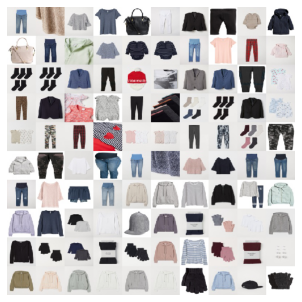

In [15]:
docs.plot_image_sprites() # Preview the images

## Preprocess Data

In [16]:
# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

In [17]:
# apply en masse
docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 100                                   
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       100              False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   100              False            
  uri         ('str',)       100              False            
                                                               
                       Storage Summary                       
                                                             
  Backend                  Qdrant                            
  Host                     localhost                         
  Port                     6333                              
  Collection Name          79b4b0ed8f1540edaceb35ebdbd8571c  
  Distance                 cosine                            
  Serialization Protocol

## Embed images

Using GPU is recommended when you want to do image search on large scale. 

In [18]:
# Use GPU if available
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

We use the ResNet50 model to embed our images. 

In [19]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

In [ ]:
docs.embed(model, device=device, batch_size=20)

We can remove the tensor of the images to reduce remory usage. This will significantly improve the speed of the `.find()` operation below.

In [21]:
docs[:, 'tensor'] = None

## 6. Query dataset

Let's query the dataset with one of the images of the dataset. We've stored this in `data/query.jpg`. Feel free to choose any jpg image of clothing as query image.

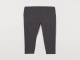

In [22]:
query_doc = Document(uri=QUERY_IMAGE)
query_doc.display()

In [23]:
query_doc = preproc(query_doc)

In [ ]:
query_doc.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

In [25]:
top10 = docs.find(query_doc, limit=10)

Show the result:

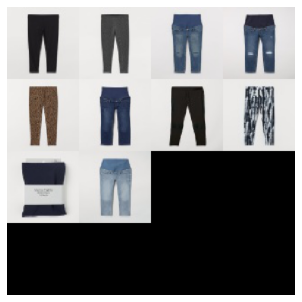

In [26]:
top10.plot_image_sprites(image_source='uri')

That's it! You can change the example query image and try out more searches yourself.